In [2]:
pip install --upgrade tensorflow-federated


  Using cached tensorflow_federated-0.71.0-py3-none-manylinux_2_31_x86_64.whl.metadata (4.0 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached dm_tree-0.1.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (152 kB)
  Using cached dp_accounting-0.4.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached farmhashpy-0.4.0.tar.gz (98 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached google_vizier-0.1.11-py3-none-any.whl.metadata (10 kB)
  Using cached grpcio-1.60.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached jaxlib-0.4.14-cp310-cp310-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached jax-0.4.14.tar.gz (1.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done


In [1]:
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade pandas
!pip install --quiet --upgrade matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.12 requires pandas~=1.4, but you have pandas 2.2.0 which is incompatible.


In [2]:
!pip install --upgrade pip

In [3]:
import collections
import os
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import time

from matplotlib import pyplot as plt

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

/tmp/ipykernel_6388/3403798242.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-14 05:11:22.517619: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 05:11:22.734427: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 05:11:22.734488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT 

In [4]:
tp = 'cic'      # Type: choose between 'cic' and 'custom'
tm = 90        # Timeout: choose one value from the following list [15, 30, 60, 90, 120, 180]
n_workers = 2   # #workers: choose between 2 and 5 workers (2 and 5 inclusive)

In [5]:
df_train = pd.read_csv('/workspaces/Network_Intrusion_Detection/train_180_cicflow.csv')
df_test = pd.read_csv('/workspaces/Network_Intrusion_Detection/test_180_cicflow.csv')

In [6]:
df_train.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min       int64
Label         object
Length: 84, dtype: object

In [7]:
df_test.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min     float64
Label         object
Length: 84, dtype: object

In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            1536 non-null   object 
 1   Src IP             1536 non-null   object 
 2   Src Port           1536 non-null   int64  
 3   Dst IP             1536 non-null   object 
 4   Dst Port           1536 non-null   int64  
 5   Protocol           1536 non-null   int64  
 6   Timestamp          1536 non-null   object 
 7   Flow Duration      1536 non-null   int64  
 8   Tot Fwd Pkts       1536 non-null   int64  
 9   Tot Bwd Pkts       1536 non-null   int64  
 10  TotLen Fwd Pkts    1536 non-null   int64  
 11  TotLen Bwd Pkts    1536 non-null   int64  
 12  Fwd Pkt Len Max    1536 non-null   int64  
 13  Fwd Pkt Len Min    1536 non-null   int64  
 14  Fwd Pkt Len Mean   1536 non-null   float64
 15  Fwd Pkt Len Std    1536 non-null   float64
 16  Bwd Pkt Len Max    1536 

In [8]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [9]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [10]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [11]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

/tmp/ipykernel_6388/3176878993.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
/tmp/ipykernel_6388/3176878993.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)


In [35]:

# train = df_train
# test = df_test
train = df_train.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
test = df_test.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])

In [36]:
n_samples = int(df_train.shape[0] / n_workers)

assert n_samples > 0, "Each worker must be assigned at least one data point"

In [37]:
n_epochs = 10
shuffle_buffer_size = df_train.shape[0]
batch_size = 250
prefetch_buffer_size = 50
input_shape = train.shape[1] - 1
output_shape = len(unique_codes)

In [38]:
def preprocess(dataframe):
    
    
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


client_data = [preprocess(train.sample(n=n_samples)) for _ in range(n_workers)]

In [39]:
for i in range(n_workers):
    print(f"Worker {i+1} data contains {len(client_data[i])} training points")

Worker 1 data contains 72 training points
Worker 2 data contains 72 training points


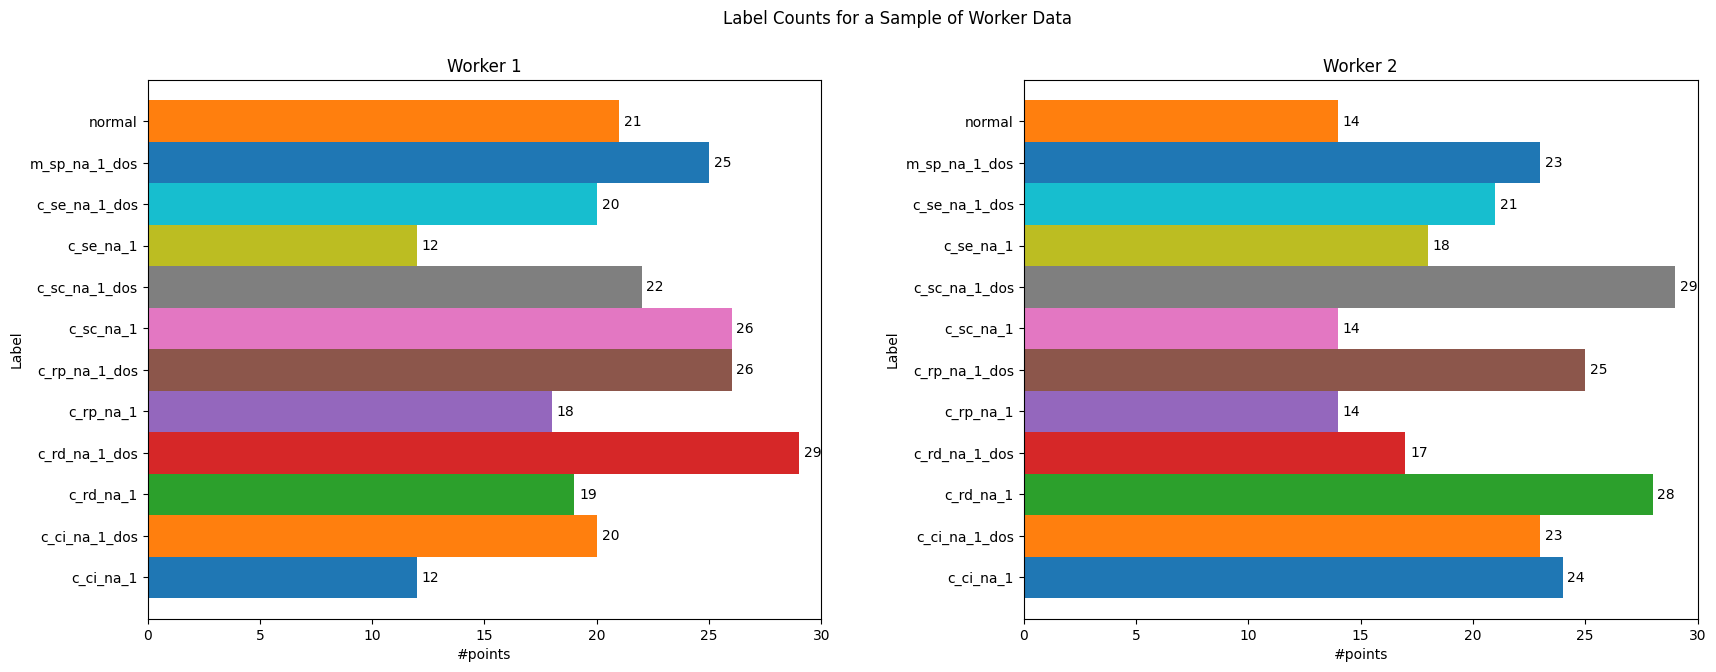

In [40]:
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    for label in list(client_data[i])[0]['y'].numpy()[:,0]:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(5-m%5)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+0.6, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

In [20]:
# def model_fn():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_shape,)),
#         tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
#         tf.keras.layers.Softmax(),
#     ])

#     return tff.learning.from_compiled_keras_model(model,
#         # Note: input spec is the _batched_ shape, and includes the 
#         # label tensor which will be passed to the loss function. This model is
#         # therefore configured to accept data _after_ it has been preprocessed.
#         input_spec=collections.OrderedDict(
#             x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
#             y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [21]:
# def model_fn():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_shape,)),
#         tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
#         tf.keras.layers.Softmax(),
#     ])
#     return tff.learning.from_keras_model(
#         model,
#         input_spec=collections.OrderedDict(
#             x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
#             y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [41]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape,)),
        tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
        tf.keras.layers.Softmax(),
    ])
    return tff.learning.models.from_keras_model(model,
        # Note: input spec is the _batched_ shape, and includes the 
        # label tensor which will be passed to the loss function. This model is
        # therefore configured to accept data _after_ it has been preprocessed.
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [42]:
print(trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[76,12],
      float32[12]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[76,12],
    float32[12]
  >
>@SERVER)


In [43]:
def evaluate(num_rounds=10):
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data)
        state = result.state
        train_metrics = result.metrics['client_work']['train']
        finalizer_value = result.finalizer[0] if isinstance(result.finalizer, list) else result.finalizer
        t2 = time.time()
        print('Round {}: loss {}, finalizer {}, round time {}'.format(
            round+1, train_metrics['loss'], finalizer_value, t2 - t1))

In [44]:
import grpc
ip_address = ['0.0.0.0'] * n_workers  #@param {type:"string"}
ports = [80+i for i in range(n_workers)]  #@param {type:list["integer"]}

channels = [grpc.insecure_channel(f'{ip_address[i]}:{ports[i]}') for i in range(len(ports))]

tff.backends.native.set_sync_local_cpp_execution_context(channels)

In [45]:
evaluate(n_epochs)

2024-02-14 05:29:35.377381: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-14 05:29:35.377531: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-14 05:29:35.388959: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-14 05:29:35.389086: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


TypeError: 'list' object cannot be interpreted as an integer

In [30]:
tf.test.gpu_device_name()

''